# Plot 2D corrtag images for a given of time ranges
Author: Jo Taylor

Date: Nov 1. 2023

In [26]:
# This makes the notebook fill the length of the browser window
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display("text/html", "<style>.container { width:100% !important; }</style>")

'text/html'

'<style>.container { width:100% !important; }</style>'

In [28]:
from astropy.io import fits
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
params={'legend.fontsize':'18','axes.labelsize':'18',
        'axes.titlesize':'18','xtick.labelsize':'18',
        'ytick.labelsize':'18','lines.linewidth':2,
        'axes.linewidth':2,'animation.html': 'html5',
        'figure.figsize':(15,15)}
plt.rcParams.update(params)

from acdc.database.query_cos_dark import files_by_mjd

## To connect to your local database, change `dbname` below.
This should include the full path of the database, e.g. `/path/to/cos_dark.db`. If in the current directory, do not include `.` or `./`, simply use `cos_dark.db`.

In [3]:
# Given an MJD start and end, return list of corrtag files
def get_corrtag_files(mjdstart, mjdend, segment="FUVA", hv=167):
    df = files_by_mjd(mjdstart, mjdend, segment=segment, hv=hv, dbname="cos_dark")
    files = df["fileloc"].to_list()
    return files

## In the below cell, you can change the date ranges in `time_ranges`, or add more key/values pairs for other time ranges of interest.
All time ranges will be plotted as separate figures later.

In [8]:
# MJD dates to query the database on. These can be changed as desired, or more key/value pairs can be added.
# By default, only get SEGMENT=FUVA files and HV=167. Can change to specific value (e.g.FUVB) or * to get all
time_ranges = {"quiescent": (57754, 58000)}
#time_ranges = {"167FUVB": (57150, 57190)}
#time_ranges = {"Andrei": (57680, 57720)}
#time_ranges = {"Shutdown": (56000, 56100)}
#time_ranges = {"Before B/A Max": (56500, 56520),
#               "B/A Max": (56550, 56570),
#               "After B/A Max": (56650, 56670),
#               "B/A Min": (56740, 56760),
#               "Post": (57520, 57540)}
file_ranges = {}
for k,trange in time_ranges.items():
#    files = get_corrtag_files(mjdstart=trange[0], mjdend=trange[1], segment="FUVB", hv=167)
#    files = get_corrtag_files(mjdstart=trange[0], mjdend=trange[1], segment="FUVB", hv=175)
    print(trange[0], trange[1])
    files = get_corrtag_files(mjdstart=trange[0], mjdend=trange[1], segment="FUVA", hv=167)
    file_ranges[k] = files

57754 58000


In [9]:
print(len(files))

175

This slope and intercept defines the "PHA of interest" a.k.a. modal gain, as a function of HV.

In [3]:
m = 0.39
b = 11 - (m*167)

Not necessary to run, but to explore the PHA space for a single file, execute the below cell. `pha_interests` and `datafile` may be changed as desired. 

In [42]:
pha_interests = np.arange(0,32)
#data_file = "/astro/sveash/darks/14520/ldd301bdq_corrtag_a.fits"
#data_file = "/astro/sveash/darks/13521/lce30mxxq_corrtag_a.fits"
#data_file = "/astro/sveash/darks/14520/ldd301bdq_corrtag_b.fits"
data_file = "/astro/sveash/darks/13521/lce30mxxq_corrtag_b.fits"

Saved lce30mxxq_FUVB_phas.png


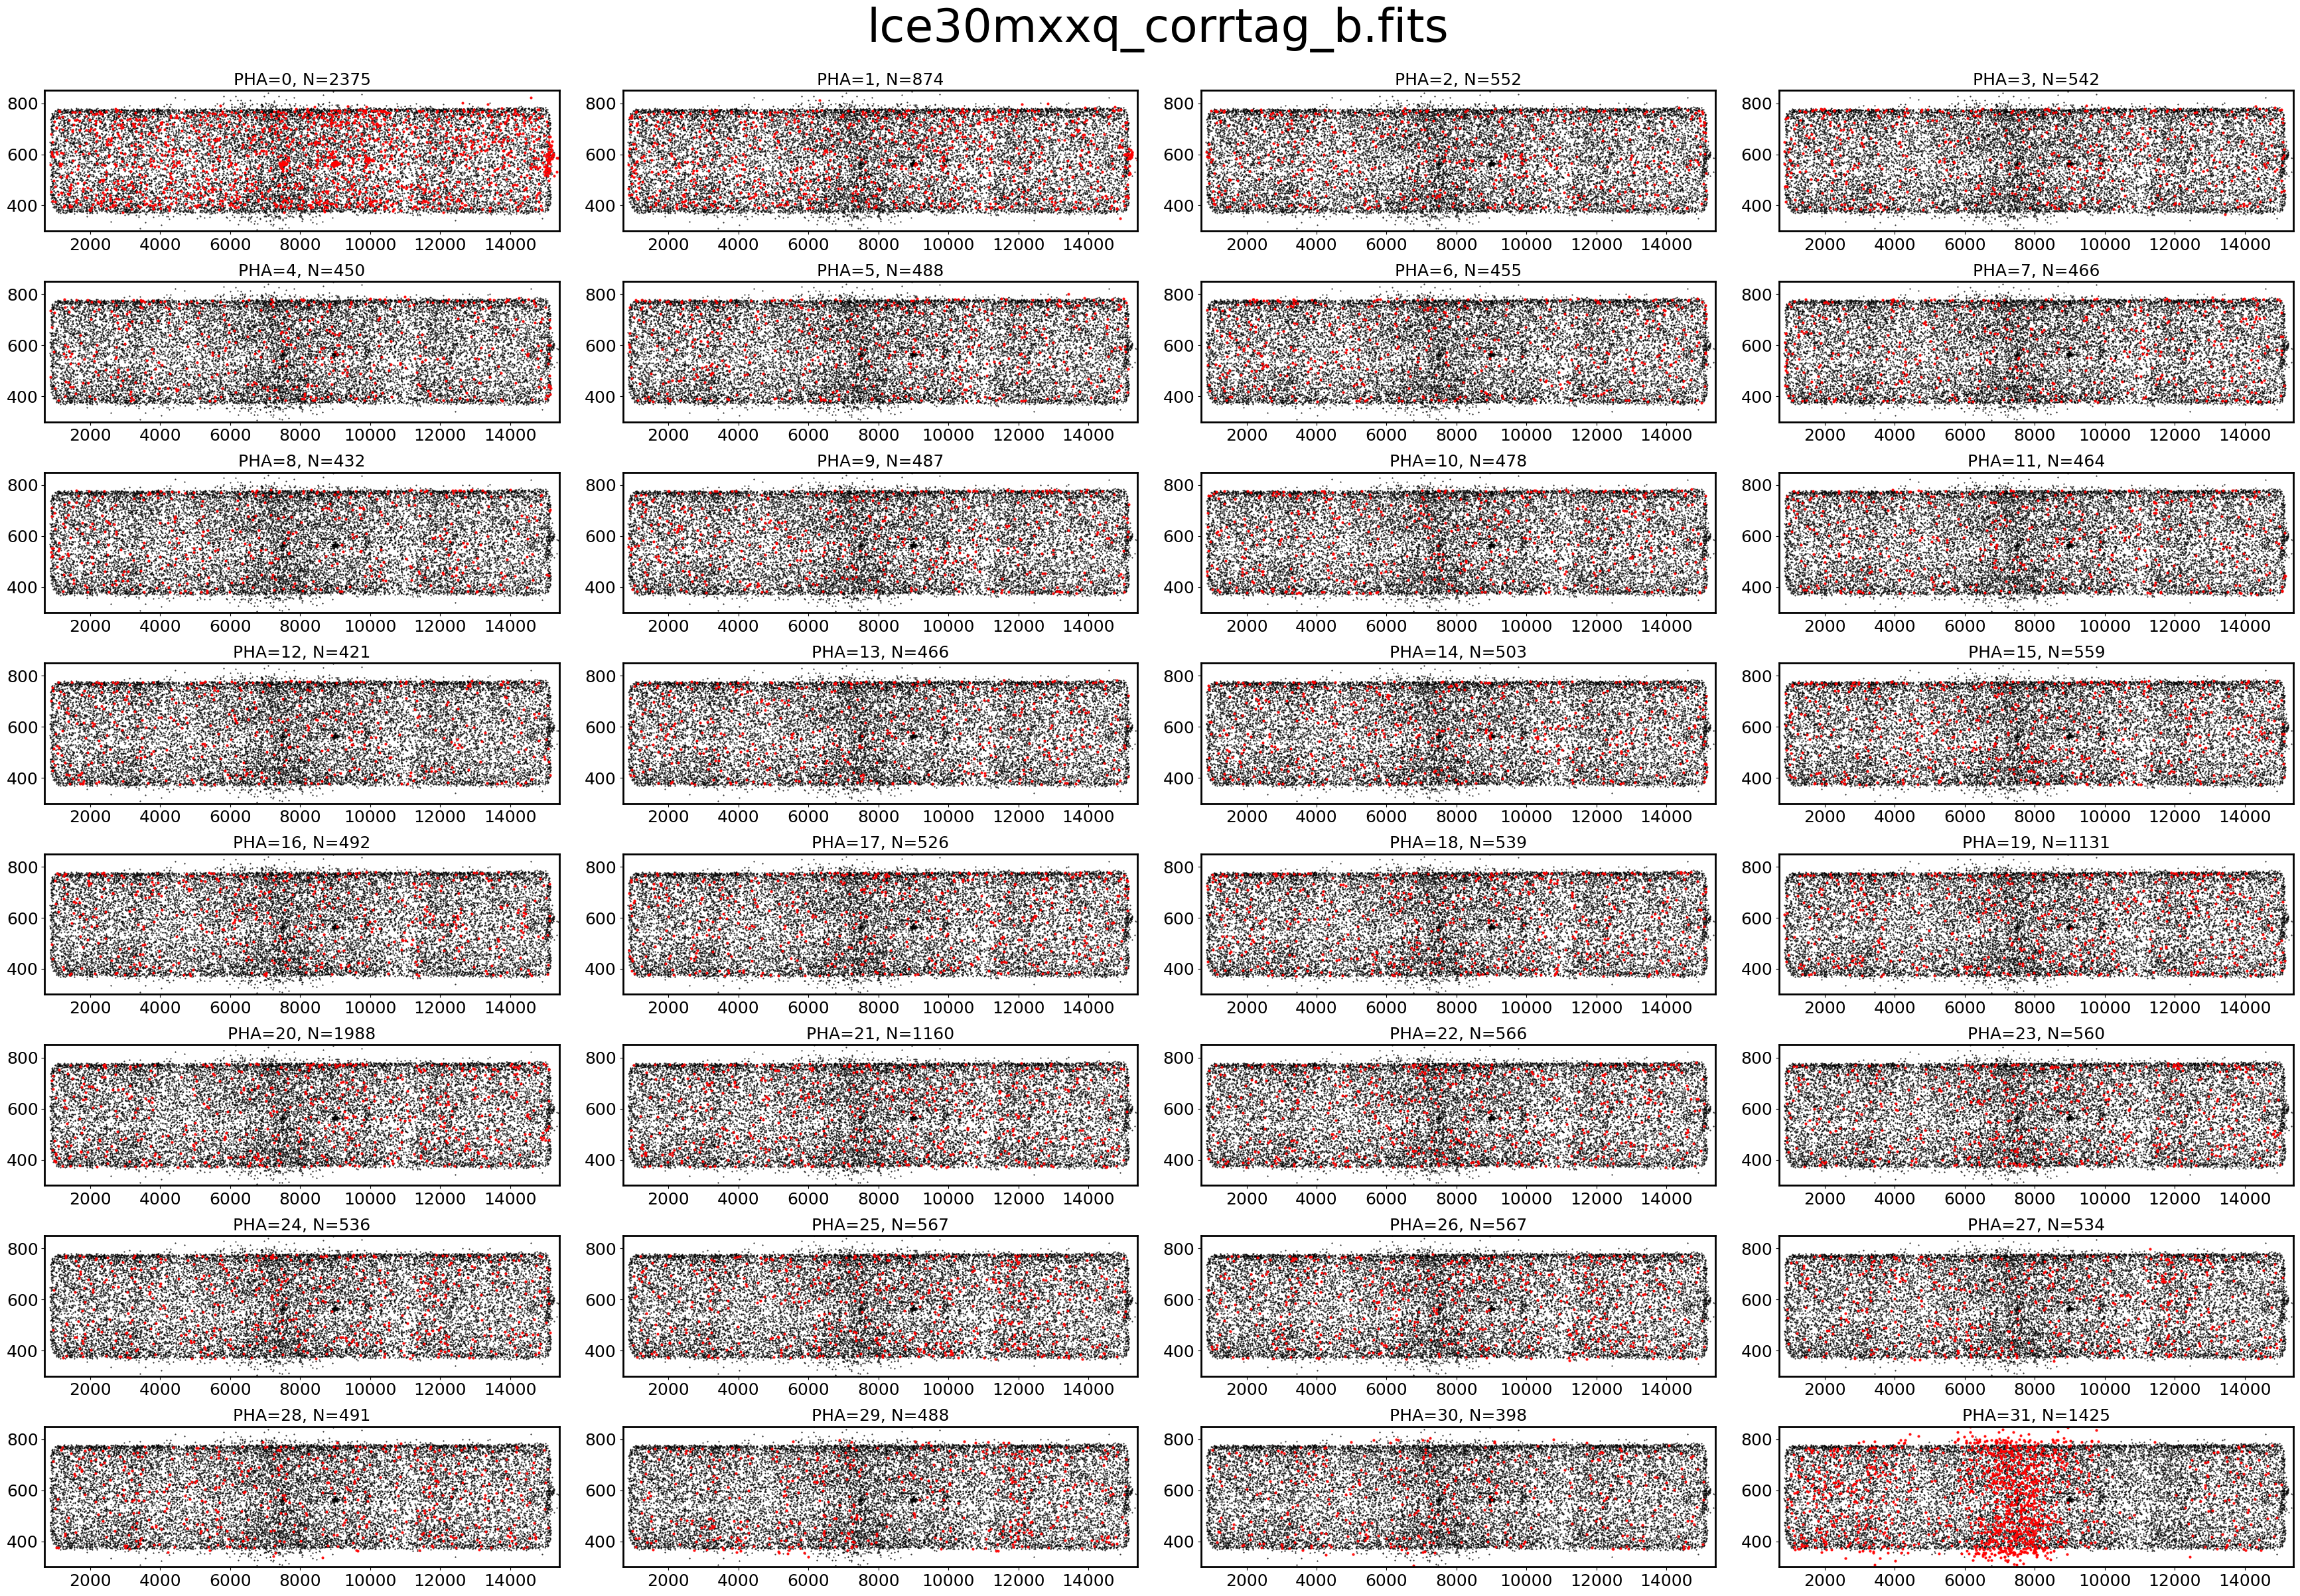

In [43]:
segment = fits.getval(data_file, "segment")
ncols = 4
nrows = int(np.ceil(len(pha_interests)/ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(35, 3*nrows))
data = fits.getdata(data_file)
for i,ax in enumerate(axes.flatten()):
    pha_interest = pha_interests[i]
    events_interest = np.where((data["pha"] < pha_interest) | (data["pha"] > pha_interest))[0]
    events_notinterest = np.where(data["pha"] == pha_interest)[0]
    ax.plot(data["xfull"][events_interest], data["yfull"][events_interest], "k.", markersize=1)
    ax.plot(data["xfull"][events_notinterest], data["yfull"][events_notinterest], "ro", markersize=2, alpha=0.9)
    ax.set_title(f"PHA={pha_interest}, N={len(events_notinterest)}")
    if segment == "FUVA":
        ax.set_xlim(800, 15500)
        ax.set_ylim(250, 800)
    else:
        ax.set_xlim(700, 15400)
        ax.set_ylim(300, 850)      
    if i == len(pha_interests)-1:
        break
fig.suptitle(os.path.basename(data_file), size=50, y=1.0)
figname = f"{os.path.basename(data_file)[:9]}_{segment}_phas.png"
fig.tight_layout()
fig.savefig(figname)
print(f"Saved {figname}")

## Plot 2D dark exposures with time

For a given PHA of interest, `pha_interest`, plot the 2D corrtag images (**XFULL**, **YFULL**) for each specified time range.

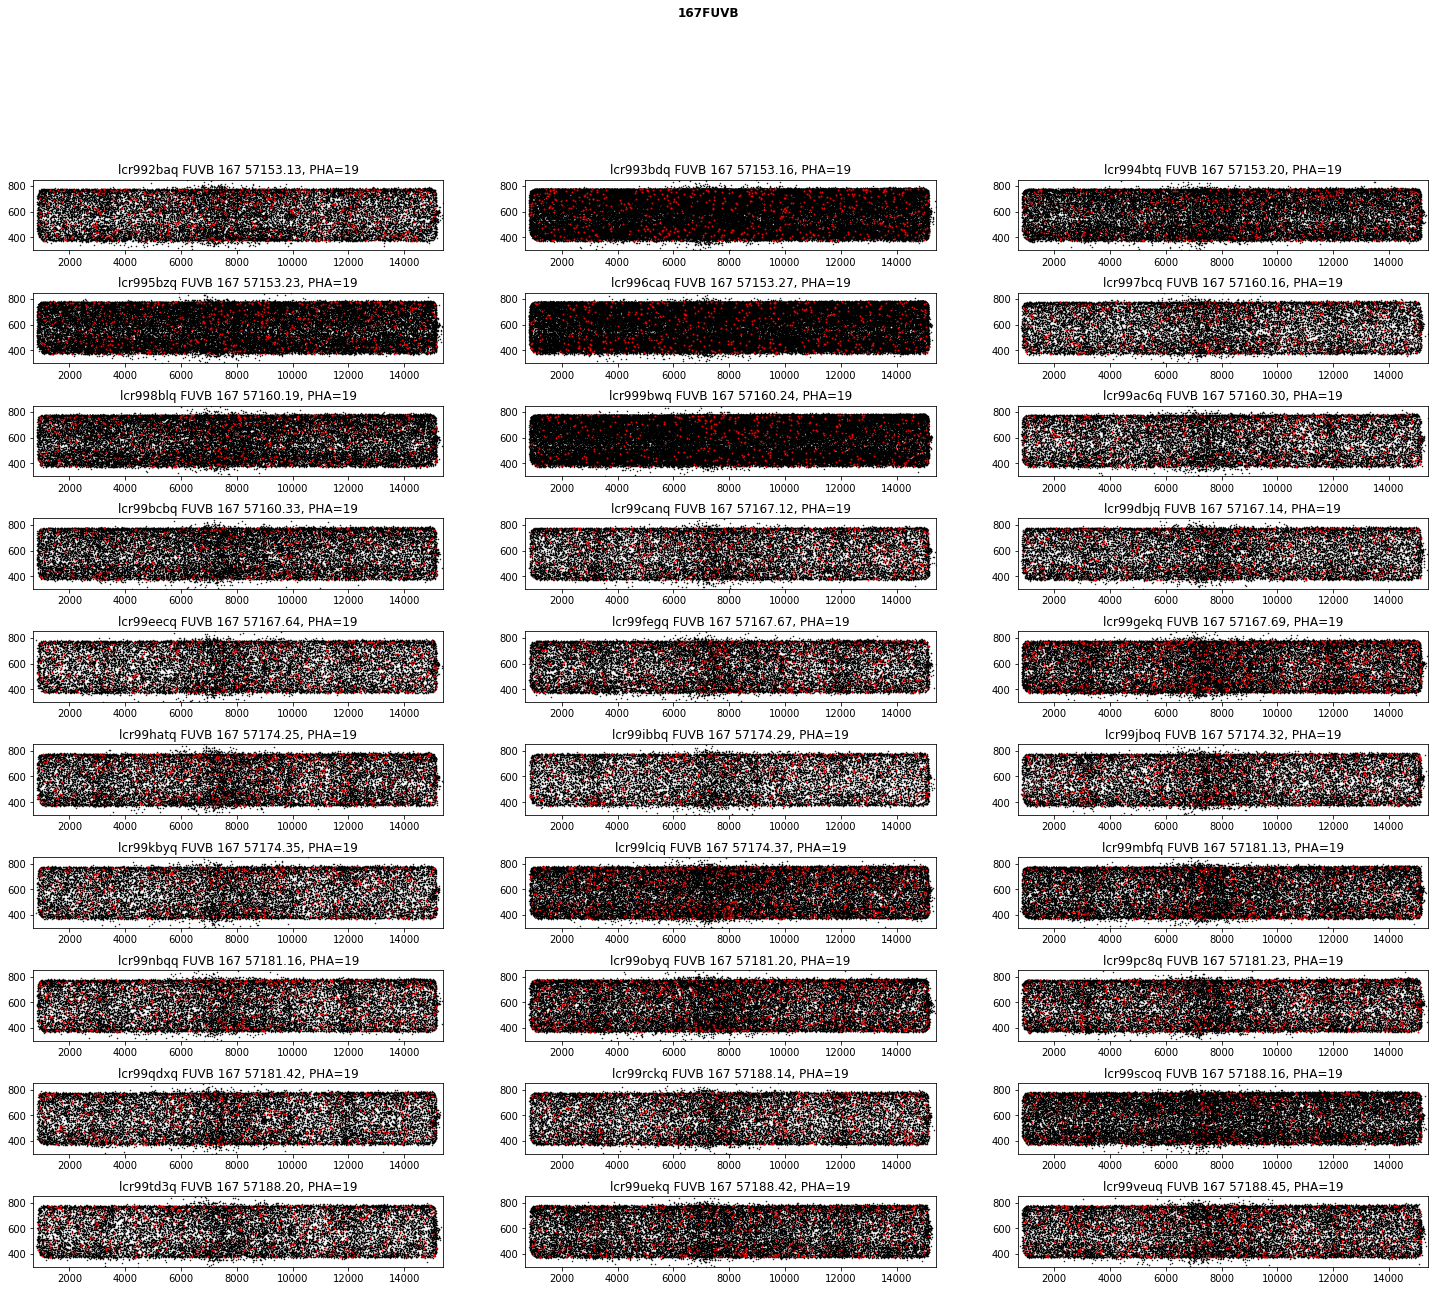

In [8]:
# Create subplots for the corrtag files as 2D images
#pha_interest = [23,24,25,26]
pha_interest = 19
#pha_interest = round(m*int(hv) + b)

for lbl, files in file_ranges.items():
    ncols = 3
    nrows = int(np.ceil(len(files)/ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(25, 2*nrows))
    plt.suptitle(lbl, y=1.0, fontweight="bold")
    plt.subplots_adjust(hspace=0.6)
    for i, ax in enumerate(axes.flatten()):
        data = fits.getdata(files[i])
        rootname = os.path.basename(files[i])[:9]
        segment = fits.getval(files[i], "segment")
        expstart = fits.getval(files[i], "expstart", 1)
        exptime = fits.getval(files[i], "exptime", 1)
        hv = fits.getval(files[i], f"HVLEVEL{segment[-1]}", 1)
        if isinstance(pha_interest, list):
            events_interest = np.where((data["pha"] < pha_interest[0]) | (data["pha"] > pha_interest[-1]))[0]
            events_notinterest = np.where((data["pha"] >= pha_interest[0]) & (data["pha"] <= pha_interest[-1]))[0]
        else:
            events_interest = np.where((data["pha"] < pha_interest) | (data["pha"] > pha_interest))[0]
            events_notinterest = np.where(data["pha"] == pha_interest)[0]
        ax.plot(data["xfull"][events_interest], data["yfull"][events_interest], "k.", markersize=1)
        ax.plot(data["xfull"][events_notinterest], data["yfull"][events_notinterest], "r.", markersize=2, alpha=0.9)
        
        #ax.set_title(f"{rootname} {segment} {hv} {expstart:.2f} {round(exptime)}, PHA={pha_interest}")
        ax.set_title(f"{rootname} {segment} {hv} {expstart:.2f}, PHA={pha_interest}")
        if segment == "FUVA":
            ax.set_xlim(800, 15500)
            ax.set_ylim(300, 800)
        else:
            ax.set_xlim(700, 15400)
            ax.set_ylim(300, 850)      